In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import cv2
import imghdr
import numpy as np
from pathlib import Path

######
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data = image_dataset_from_directory("drive/MyDrive/pothole_dataset", image_size = (240,240), shuffle= True) #batch_size=32 vardı kaldırdım
# data_set = "drive/MyDrive/pothole_dataset"

Found 5859 files belonging to 2 classes.


In [ ]:

class_names = data.class_names
class_names
len(data)

In [ ]:
image_format = ["jpeg","jpg","png","gif","bmp"]

In [ ]:
# # bu biraz dandik kod. resimleri silmiyor yada bizim verisetimizdeki fotoğralar gömülü olduğu için silmedi.
# for image_class in os.listdir(data_set): # veri setimizde jpeg, jpg, png, bmp, gif dışında formatlarda fotoğraflar olduğu için bu kod satılarını yazmak zorunda kaldık
#   for image in os.listdir(os.path.join(data_set, image_class)):  # bu format dışındaki fotoğrafları veri setimiziden sildik.
#     image_path = os.path.join(data_set, image_class, image)
#     try:
#       image = cv2.imread(image_path)
#       tip = imghdr.what(image_path)
#       if tip not in image_exts():
#         print("image not in ext list{}:".format(image_path))
#         os.remove(image_path)
#     except Exception as e:
#       print("issue with image{}".format(image_path))



# # tensowflowun istediği formatta olmayan dosyaları tespit ettik. Sonra drive'dan tek tek hepsini bulduk. Kod satırlarını yeniden başlattık.
# image_extensions = [".png", ".jpg"]

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_set).rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
for image_batch, label_batch in data.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 240, 240, 3)
[1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1]


In [ ]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in data.take(5):
  for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(data)

184

In [ ]:
train_size = 0.8
len(data)*train_size


147.20000000000002

In [ ]:
train_data = data.take(148)
len(train_data)

148

In [ ]:
test_data = data.skip(148)
len(test_data)

36

In [ ]:
valid_size = 0.1
len(data)*valid_size

18.400000000000002

In [ ]:
valid_data = test_data.take(18)
len(valid_data)

18

In [ ]:
test_data = test_data.skip(18)
len(test_data)

18

In [ ]:
print(len(train_data))
print(len(test_data))
print(len(valid_data))

148
18
18


In [ ]:

resize_rescale = tf.keras.Sequential([
    layers.Resizing(240,240),
    layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
train_data = train_data.map(
    lambda a,b: (data_augmentation(a, training = True),b)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
model = models.Sequential([
    # resize_rescale,
    Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = (240,240,3)), # 32,240,240,3
    MaxPooling2D(2,2),
    Conv2D(64, kernel_size = (3,3), activation = "relu"),
    MaxPooling2D(2,2),
    Conv2D(64, kernel_size = (3,3), activation = "relu"),
    MaxPooling2D(2,2),
    Flatten(input_shape=(240,240,3)),   # burası normalde Flatten()
    Dense(64, activation = "relu"),
    Dense(3, activation = "softmax")
])
# model.build(input_shape = (32,240,240,3))  #32,240,240,3

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 119, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)       

In [ ]:
model.compile(
    optimizer = Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    train_data,
    batch_size = 32,
    validation_data = valid_data,
    verbose = 1,
    epochs = 1   #20
)

148/148 [==============================] - 650s 4s/step - loss: 6.3739 - accuracy: 0.9181 - val_loss: 0.1402 - val_accuracy: 0.9670


In [ ]:
score = model.evaluate(test_data, verbose = 1)
print("test loss:", score[0])
print("test accuracy:", score[1])

In [ ]:
score

In [ ]:
model.save("drive/MyDrive/p3.h5")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2 as cv
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
model = load_model("drive/MyDrive/pothole_road_path_detectioon.h5")
# model1 = load_model("drive/MyDrive/cat_dog_detection.h5")
# model2 = load_model("drive/MyDrive/my_first_mnist_model_.h5")

Tahmin edilecek resim: 
Resimin gerçek adı pothole
1/1 [==============================] - 3s 3s/step
tahmin edilen [[9.99520719e-01 4.79197392e-04]
 [9.99999940e-01 0.00000000e+00]
 [9.99999106e-01 8.44142676e-07]
 [9.99975383e-01 2.45121792e-05]
 [1.86317191e-02 9.81368244e-01]
 [1.44852255e-08 9.99999940e-01]
 [9.99999940e-01 8.33339641e-27]
 [9.99998868e-01 1.07729772e-06]
 [9.99999940e-01 0.00000000e+00]
 [9.99705791e-01 2.94281897e-04]
 [3.87867098e-03 9.96121347e-01]
 [3.72398557e-04 9.99627650e-01]
 [9.99999940e-01 0.00000000e+00]
 [9.99865532e-01 1.34514266e-04]
 [9.99884188e-01 1.15693838e-04]
 [9.99999940e-01 0.00000000e+00]
 [3.41233425e-03 9.96587574e-01]
 [1.52980603e-04 9.99847174e-01]
 [9.99999940e-01 1.64945502e-10]
 [9.99999940e-01 1.34129741e-09]
 [9.99994934e-01 5.02694456e-06]
 [2.20745220e-04 9.99779224e-01]
 [9.99999940e-01 1.25556776e-09]
 [9.99999940e-01 3.98541726e-20]
 [9.99999940e-01 2.37353355e-30]
 [9.99999940e-01 1.45542947e-08]
 [8.74829362e-04 9.99125123

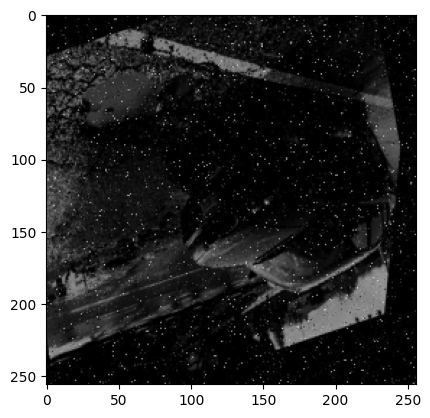

In [ ]:
# 0 ve 1'in ne anlamı var ARAŞTIRDIĞIM SORU BU

# for image_batch, label_batch in test_data.take(1):
#   image = image_batch[1].numpy().astype("uint8")
#   label = label_batch[1].numpy().astype("uint8")

#   print("Tahmin edilecek resim: ")
#   plt.imshow(image)
#   print("Resimin gerçek adı", class_names[label])
#   print(label)
#   tahmin_edilen = model.predict(image_batch)
#   print("tahmin edilen",tahmin_edilen.argmax())
#   print("tahmini: ", class_names[np.argmax(tahmin_edilen[0])])
for image_batch, label_batch in test_data.take(1):
  image = image_batch[1].numpy().astype("uint8")
  label = label_batch[1].numpy().astype("uint8")

  print("Tahmin edilecek resim: ")
  plt.imshow(image)
  print("Resimin gerçek adı", class_names[label])
  tahmin_edilen = model.predict(image_batch)
  print("tahmin edilen",tahmin_edilen)
  print("tahmin edilen",tahmin_edilen.argmax())
  print("tahmini: ", class_names[np.argmax(tahmin_edilen[0])])

In [ ]:
im = load_img("yoll.jpg", target_size=(256,256))
im = img_to_array(im)/255
im = np.expand_dims(im, axis = 0)

In [ ]:
pred = model.predict(im)

1/1 [==============================] - 0s 17ms/step


In [ ]:
pred

array([[1.0000000e+00, 2.0849539e-08]], dtype=float32)

In [ ]:
pred.argmax()

0

In [ ]:
class_names[0]

'pothole'